In [3]:
from pathlib import Path
import shutil
import yaml
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import torch
from ultralytics import settings
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Settings

See [here](https://github.com/ultralytics/assets/releases/) for the available YOLO releases. If you're planning to use Edge Impulse to convert your model to an edge runtime, you'll probably want to match up the model with one of the [available object detection output layers](https://docs.edgeimpulse.com/studio/organizations/custom-blocks/custom-learning-blocks#object-detection-output-layers).

In [8]:
# Training settings
YOLO_RELEASE_VERSION = "8.3.0"
YOLO_MODEL_NAME = "yolo11n.pt"
DATASET_PATH = Path("/workspace/dataset")
DATASET_ZIP_PATH = DATASET_PATH / "Human Face Expression.v20i.yolov8.zip"
DATASET_YAML_PATH = DATASET_PATH / "data.yaml"
MODELS_PATH = Path("/workspace/models")
PRETRAINED_MODEL_PATH = MODELS_PATH / "yolo_pretrained.pt"
RUNS_PATH = Path("/workspace/runs")
LOG_PATH = RUNS_PATH / "detect"
BEST_MODEL_PATH = LOG_PATH / "emotion_detection/weights/best.pt"
OUTPUT_MODEL_NAME = "model.onnx"

In [13]:
# Training hyperparameters (https://docs.ultralytics.com/modes/train/#train-settings)
TRANSFER_EPOCHS = 50      # Number of full passes over training dataset during transfer learning
FINE_TUNING_EPOCHS = 50   # Number of full passes over training dataset during fine tuning
BATCH_SIZE = 16           # Number of training samples processed before updating parameters
IMG_SIZE = 640            # Target image size (assumes square aspect ratio)
FREEZE_LAYERS = 10        # Freeze the first N layers of the model (backbone) for transfer learning
NUM_WORKERS = 4           # Number of worker threads for data loading

In [14]:
# Inference settings
CONFIDENCE_THRESHOLD = 0.01

In [15]:
# Determine if we should execute on the CPU or GPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon (Metal Performance Shaders)
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


In [16]:
# For Jupyter Lab: show plots in the cells (instead of trying to open a new window)
%matplotlib inline

## Download dataset

**Manual step required**: Because Roboflow's API key expires every 24 hours, the easiest way to download the dataset is to manually grab it from Roboflow's site.

1. Sign in or create an account on [Roboflow](https://roboflow.com/).
2. Head to the [Human Face Expression Recognition dataset (v20)](https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20) on Roboflow.
3. Click **YOLOv8** under *Popular Download Formats**.
4. In the pop-up window, select **Download dataset** and click **Continue**.
5. In the next window, ensure that *YOLOv8* is selected under *Image and Annotation Format*. Select **Download zip to computer** and click **Continue**.
6. Copy the *.zip* file to the *workspace/dataset/* directory.
7. Run the following cells to unzip the dataset and check it.

In [ ]:
# Unzip dataset
with zipfile.ZipFile(DATASET_ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [5]:
# Load the YAML
with open(DATASET_YAML_PATH, "r") as f:
    data_config = yaml.safe_load(f)

# Extract class names
class_names = data_config["names"]
num_classes = len(class_names)

# Display contents
print("data.yaml contents:")
for k, v in data_config.items():
    print(f"{k}: {v}")

data.yaml contents:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 7
names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
roboflow: {'workspace': 'human-face-expression-recognition', 'project': 'human-face-expression', 'version': 20, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20'}


## Download model

In [9]:
# Download model weights (pre-trained on COCO)
!wget https://github.com/ultralytics/assets/releases/download/v{YOLO_RELEASE_VERSION}/{YOLO_MODEL_NAME} -O {PRETRAINED_MODEL_PATH}

--2025-11-18 20:48:29--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/34b70ade-b6eb-4179-a60f-d6494307226b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-18T21%3A28%3A17Z&rscd=attachment%3B+filename%3Dyolo11n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-18T20%3A27%3A52Z&ske=2025-11-18T21%3A28%3A17Z&sks=b&skv=2018-11-09&sig=rUbBzn2UEG8%2Bqial%2BeX8d%2B0UOgdLwm%2BxlYpyb7zdqdw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzQ5OTIxMCwibmJmIjoxNzYzNDk4OTEwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iL

## Transfer Learning

In [11]:
# Enable TensorBoard logging
settings.update({'tensorboard': True})

# Load the YOLOv8-nano model (pretrained on COCO dataset)
model = YOLO(PRETRAINED_MODEL_PATH)

# Print model info
print(f"Model summary: {model.model.info()}")

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
Model summary: (181, 2624080, 0, 6.614336)


In [17]:
# Train with frozen backbone (transfer learning)
results = model.train(
    data=DATASET_YAML_PATH,
    epochs=TRANSFER_EPOCHS,
    freeze=FREEZE_LAYERS,

    # Learning rates
    lr0=0.01,
    lrf=0.01,
    
    # Regularization
    dropout=0.3,           # Add dropout (0.0 to 0.5, start with 0.1)
    weight_decay=0.001,    # L2 regularization (default 0.0005, try 0.001)
    label_smoothing=0.1,   # Smooth hard labels (0.0 to 0.2)
    
    # Data augmentation
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=5,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,

    # Other hyperparameters
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=device,
    workers=NUM_WORKERS,
    project=LOG_PATH,
    name='emotion_detection',
    exist_ok=True,
    verbose=True,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.228 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/workspace/dataset/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.3, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/workspace/models/yolo_pretrained.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=emotion_detection,

In [18]:
# Load the best model weights (highest mAP50-95) from transfer learning
yolo_fine_tune = YOLO(BEST_MODEL_PATH)

In [19]:
# Fine-tune with unfrozen backbone
results = yolo_fine_tune.train(
    data=DATASET_YAML_PATH,
    epochs=FINE_TUNING_EPOCHS,
    freeze=0,               # Unfreeze all layers
    
    # Lower learning rates (TODO: these don't seem to be working!)
    lr0=0.0001,
    lrf=0.00001,
    
    # Keep regularization
    dropout=0.1,
    weight_decay=0.001,
    label_smoothing=0.1,
    
    # Augmentation
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=5,
    translate=0.1,
    scale=0.5,
    
    # Other params
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=device,
    workers=NUM_WORKERS,
    project=LOG_PATH,
    name='emotion_detection_fine_tune',
    exist_ok=True,
    verbose=True
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.228 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/workspace/dataset/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=1e-05, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/workspace/runs/detect/emotion_detection/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

## Test retrained model

In [22]:
# Load the best model
best_model = YOLO(BEST_MODEL_PATH)

# Run validation on the test/validation set
metrics = best_model.val(
    data=DATASET_YAML_PATH,
    split='test',  # Or 'val' depending on your data.yaml
    batch=16,
    imgsz=640,
    device=device,
    plots=True,  # Generate confusion matrix, PR curves, etc.
    save_json=False,
    conf=0.001,  # Lower confidence to get all predictions for metrics
    iou=0.6  # NMS IoU threshold
)

Ultralytics 8.3.228 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 1.2±0.1 ms, read: 15.2±4.4 MB/s, size: 30.8 KB)
val: Scanning /workspace/dataset/test/labels.cache... 122 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 122/122 175.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.9it/s 2.0s0.2ss
                   all        122        329      0.716      0.775      0.797       0.55
                 angry         50         77       0.73      0.727       0.85       0.62
                  fear         25         48      0.804       0.77      0.882      0.629
                 happy         47         92      0.786      0.836      0.888      0.552
               neutral         17         59      0.509      0.792      0.656      0.424
                   s

In [23]:
# Print overall metrics
print("\n=== Overall Metrics ===")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

# Print per-class metrics
print("\n=== Per-Class mAP50-95 ===")
for i, class_name in enumerate(class_names):
    print(f"{class_name:15s}: {metrics.box.maps[i]:.4f}")


=== Overall Metrics ===
mAP50: 0.7970
mAP50-95: 0.5504
Precision: 0.7161
Recall: 0.7751

=== Per-Class mAP50-95 ===
angry          : 0.6205
disgust        : 0.5504
fear           : 0.6290
happy          : 0.5521
neutral        : 0.4242
sad            : 0.3567
surprise       : 0.7197


## Convert to ONNX

In [24]:
# Export model
exported_path = best_model.export(
    format='onnx',
    imgsz=IMG_SIZE,
    simplify=True,    # Uses onnxslim for optimization
    dynamic=False,    # Disable dynamic input size (must be static resolution=imgsz)
    half=False,       # Use 32-bit floating point (half is 16-bit)
    nms=True,         # Include non-maximum suppression (NMS)
)

# Copy model to the output directory
model_dest = MODELS_PATH / OUTPUT_MODEL_NAME
shutil.copy(exported_path, model_dest)
print(f"Model saved to {model_dest}")

Ultralytics 8.3.228 🚀 Python-3.10.12 torch-2.9.1+cu128 CPU (11th Gen Intel Core i7-11800H @ 2.30GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/workspace/runs/detect/emotion_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.2 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 1.5s, saved as '/workspace/runs/detect/emotion_detection/weights/best.onnx' (10.1 MB)

Export complete (1.6s)
Results saved to /workspace/runs/detect/emotion_detection/weights
Predict:         yolo predict task=detect model=/workspace/runs/detect/emotion_detection/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/workspace/runs/detect/emotion_detection/weights/best.onnx imgsz=640 data=/workspace/dataset/data.yaml  
Visualize:       https://netron.app


## Define image preprocessing functions

The Ultralytics train method automatically handles image preprocessing (scaling, letterboxing) along with scaling the bounding boxes. The exported ONNX file, however, does not provide this functionality, so we need to write our own functions.

In [25]:
def preprocess_image(
    img,
    target_w=640,
    target_h=640,
    bg_color=(0, 0, 0),
):
    """Load and preprocess an image for training"""
    # Convert image to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Calculate new width and height in order to maintain aspect ratio
    h, w = img.shape[:2]
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))

    # Resize with aspect ratio maintained
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Compute padding (center the image)
    pad_w, pad_h = target_w - new_w, target_h - new_h
    pad_left, pad_right = pad_w // 2, pad_w - pad_w // 2
    pad_top, pad_bottom = pad_h // 2, pad_h - pad_h // 2

    # Apply border padding (black background)
    img_padded = cv2.copyMakeBorder(
        img_resized,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=bg_color,
    )

    return img_padded, scale, pad_left, pad_top

In [26]:
def scale_bboxes_to_yolo(
    boxes, 
    orig_w, 
    orig_h, 
    target_w, 
    target_h, 
    scale, 
    pad_left, 
    pad_top,
):
    """Scale YOLO-format bounding boxes after image preprocessing"""
    # Make sure we have boxes
    if len(boxes) == 0:
        return boxes

    # Convert boxes to float32
    boxes = np.array(boxes, dtype=np.float32)

    # Convert from normalized to original pixel coordinates
    cls = boxes[:, 0]
    xc = boxes[:, 1] * orig_w
    yc = boxes[:, 2] * orig_h
    bw = boxes[:, 3] * orig_w
    bh = boxes[:, 4] * orig_h

    # Apply scaling and padding
    xc = xc * scale + pad_left
    yc = yc * scale + pad_top
    bw *= scale
    bh *= scale

    # Convert back to normalized YOLO format (new image dimensions)
    xc /= target_w
    yc /= target_h
    bw /= target_w
    bh /= target_h

    # Re-stack into [cls, xc, yc, bw, bh]
    new_boxes = np.stack([cls, xc, yc, bw, bh], axis=1)
    
    return new_boxes.astype(np.float32)

In [27]:
def scale_bboxes_to_original(bboxes, scale, pad_left, pad_top, orig_w, orig_h):
    """Scale boxes from 640x640 padded image back to original image size"""
    scaled_bboxes = []
    
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        
        # Remove padding
        x1 = x1 - pad_left
        y1 = y1 - pad_top
        x2 = x2 - pad_left
        y2 = y2 - pad_top
        
        # Scale back to original size
        x1 = x1 / scale
        y1 = y1 / scale
        x2 = x2 / scale
        y2 = y2 / scale
        
        # Clip to image bounds
        x1 = max(0, min(x1, orig_w))
        y1 = max(0, min(y1, orig_h))
        x2 = max(0, min(x2, orig_w))
        y2 = max(0, min(y2, orig_h))
        
        scaled_bboxes.append([x1, y1, x2, y2])
    
    return scaled_bboxes

In [28]:
def predictions_to_yolo_format(bboxes, class_ids, img_w, img_h):
    """Convert [x1, y1, x2, y2] predictions to YOLO format [cls, xc, yc, w, h]"""
    yolo_labels = []

    # Loop through all bounding boxes
    for bbox, class_id in zip(bboxes, class_ids):
        x1, y1, x2, y2 = bbox
        
        # Convert to center format
        xc = (x1 + x2) / 2
        yc = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        
        # Normalize to [0, 1]
        xc /= img_w
        yc /= img_h
        w /= img_w
        h /= img_h
        
        yolo_labels.append([class_id, xc, yc, w, h])
    
    return np.array(yolo_labels, dtype=np.float32)

In [29]:
def img_to_np(img):
    """Convert an image to a normalized NumPy array"""
    # Ensure 3-channel RGB shape
    if img.ndim == 2:
        # Grayscale image (H, W), copy image to all three channels
        img = np.repeat(img[..., None], 3, axis=2)
    elif img.ndim == 3 and img.shape[2] == 1:
        # Single-channel image (H, W, 1), copy image to all three channels
        img = np.repeat(img, 3, axis=2)
    elif img.ndim == 3 and img.shape[2] == 3:
        # Already RGB, do nothing
        pass
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    # Reorder image (H, W, C) to (C, H, W) format
    img = np.transpose(img, (2, 0, 1))
    
    # Convert to float32 and normalize from [0, 255] to [0.0, 1.0]
    img = img.astype(np.float32) / 255.0

    return img

In [30]:
def visualize_sample(img_np, bboxes, class_names, color=(255, 0 ,0)):
    """Display an image and bounding boxes from the dataset."""
    # Convert normalized tensor in (C, H, W) to uint8 array in (H, W, C)
    img = (img_np.transpose(1, 2, 0) * 255).astype(np.uint8)

    # Get height and width
    h, w = img.shape[:2]

    # Draw bounding box and label
    for bbox in bboxes:
        cls, xc, yc, bw, bh = bbox
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        label = f"{int(cls)}"
        if class_names:
            label += f" ({class_names[int(cls)]})"
        cv2.putText(
            img, 
            label, 
            (x1 + 5, y2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1.0, 
            color, 
            2,
        )

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Test inference with ONNX Runtime

[          3     0.12188     0.13438     0.19688     0.23281]
[          3     0.62344     0.12344     0.17656       0.225]
[          3     0.87813     0.12969     0.17969     0.21563]
[          3     0.11875     0.37344     0.19219       0.225]
[          3     0.88125     0.38281     0.20781     0.22969]
[          3     0.36875     0.88281     0.20156     0.21563]
[          3     0.62969     0.88281     0.18438     0.20781]
[          0     0.37187     0.12812     0.20156     0.21563]
[          0     0.37187     0.38281     0.17656     0.21563]
[          0     0.87187     0.87031     0.20781     0.20781]
[          2     0.62656     0.38281     0.20312     0.22813]
[          2     0.36719     0.63594     0.18906     0.21875]
[          2     0.62031     0.62969     0.20625       0.225]
[          4     0.12344     0.62813     0.19219     0.23281]
[          4     0.87969     0.62656     0.18438     0.23281]
[          5     0.12969     0.88125     0.17031     0.21563]


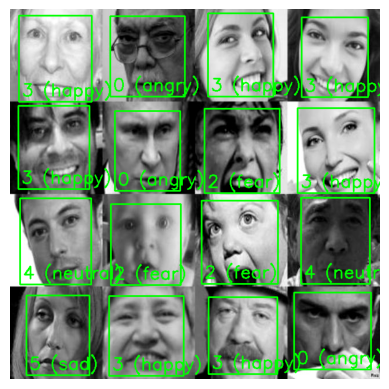

In [31]:
# Choose a single image and get bounding box info (label)
img_path = DATASET_PATH / "test/images" / "72_jpg.rf.95fd56a9abd0969b956f67d57ded930e.jpg"
label_path = DATASET_PATH / "test/labels" / (img_path.stem + ".txt")

# Load image
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

# Get image dimensions
img_h = img.shape[0]
img_w = img.shape[1]

# Get a NumPy array version of the image
img_np = img_to_np(img)

# Load bounding boxes
bboxes = []
with open(label_path) as f:
    for line in f:
        bboxes.append(list(map(float, line.strip().split())))
bboxes = np.array(bboxes, dtype=np.float32)

# Show image
for bbox in bboxes:
    print(bbox)
visualize_sample(img_np, bboxes, class_names, (0, 255, 0))

tensor([3.0000, 0.1219, 0.1344, 0.1969, 0.2328])
tensor([3.0000, 0.6234, 0.1234, 0.1766, 0.2250])
tensor([3.0000, 0.8781, 0.1297, 0.1797, 0.2156])
tensor([3.0000, 0.1187, 0.3734, 0.1922, 0.2250])
tensor([3.0000, 0.8813, 0.3828, 0.2078, 0.2297])
tensor([3.0000, 0.3688, 0.8828, 0.2016, 0.2156])
tensor([3.0000, 0.6297, 0.8828, 0.1844, 0.2078])
tensor([0.0000, 0.3719, 0.1281, 0.2016, 0.2156])
tensor([0.0000, 0.3719, 0.3828, 0.1766, 0.2156])
tensor([0.0000, 0.8719, 0.8703, 0.2078, 0.2078])
tensor([2.0000, 0.6266, 0.3828, 0.2031, 0.2281])
tensor([2.0000, 0.3672, 0.6359, 0.1891, 0.2188])
tensor([2.0000, 0.6203, 0.6297, 0.2062, 0.2250])
tensor([4.0000, 0.1234, 0.6281, 0.1922, 0.2328])
tensor([4.0000, 0.8797, 0.6266, 0.1844, 0.2328])
tensor([5.0000, 0.1297, 0.8813, 0.1703, 0.2156])


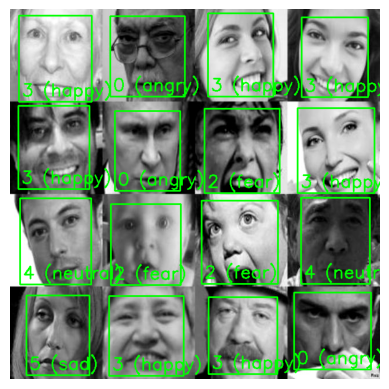

In [32]:
# Preprocess the above image
target_w = 640
target_h = 640
img_proc, scale, pad_left, pad_top = preprocess_image(img, target_w, target_h)

# Get a tensor version of the image
img_tensor = img_to_np(img_proc)

# Scale the associated bounding boxes to match the letterboxed image
bboxes_proc = scale_bboxes_to_yolo(
    bboxes,
    img_w,
    img_h,
    target_w, 
    target_h,
    scale, 
    pad_left, 
    pad_top
)

# Convert bounding boxes to tensor
if len(bboxes_proc) > 0:
    labels = torch.tensor(bboxes_proc)
else:
    labels = torch.zeros((0, 5))

# Show image
for label in labels:
    print(label)
visualize_sample(img_tensor, labels, class_names, (0, 255, 0))

In [33]:
# Load ONNX model
session = ort.InferenceSession(
    model_dest,
    providers=['CPUExecutionProvider']
)

# Get model info
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape
output_name = session.get_outputs()[0].name
output_shape = session.get_outputs()[0].shape

print(f"Model loaded: {model_dest}")
print(f"Input: {input_name}, shape: {input_shape}")
print(f"Output: {output_name}, shape: {output_shape}")

Model loaded: /workspace/models/model.onnx
Input: images, shape: [1, 3, 640, 640]
Output: output0, shape: [1, 300, 6]


In [34]:
# Load image
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

# Preprocess the image
target_w = 640
target_h = 640
img_proc, scale, pad_left, pad_top = preprocess_image(img, target_w, target_h)

# Convert to NumPy array with correct shape (batch size of 1)
img_np = img_to_np(img_proc)
img_np_batched = np.expand_dims(img_np, axis=0)
print(f"Image shape: {img_np_batched.shape}")

Image shape: (1, 3, 640, 640)


In [35]:
# Run inference
outputs = session.run([output_name], {input_name: img_np_batched})

# Get just the detections
detections = outputs[0][0]

# Format: [x1, y1, x2, y2, confidence, class_id]
pred_boxes = []
pred_scores = []
pred_classes = []

# Get each of the bounding boxes
for detection in detections:
    x1, y1, x2, y2, confidence, class_id = detection
    
    # Filter out anything below our confidence threshold
    if confidence > CONFIDENCE_THRESHOLD:
        pred_boxes.append([x1.item(), y1.item(), x2.item(), y2.item()])
        pred_scores.append(float(confidence))
        pred_classes.append(int(class_id))

# Print the raw detections (note: NMS is included in ONNX model)
for i in range(len(pred_boxes)):
    print(f"{pred_classes[i]} ({class_names[pred_classes[i]]}) with confidence " \
        f"{round(pred_scores[i], 2)} at {[round(v) for v in pred_boxes[i]]}")

3 (happy) with confidence 0.93 at [496, 6, 624, 154]
3 (happy) with confidence 0.91 at [17, 168, 145, 311]
3 (happy) with confidence 0.88 at [336, 6, 464, 152]
3 (happy) with confidence 0.87 at [344, 490, 470, 637]
3 (happy) with confidence 0.86 at [496, 172, 633, 316]
3 (happy) with confidence 0.85 at [165, 492, 309, 639]
3 (happy) with confidence 0.85 at [7, 3, 146, 157]
0 (angry) with confidence 0.84 at [328, 170, 466, 317]
2 (fear) with confidence 0.82 at [329, 329, 461, 478]
4 (neutral) with confidence 0.79 at [22, 332, 147, 475]
0 (angry) with confidence 0.67 at [490, 490, 635, 639]
0 (angry) with confidence 0.64 at [499, 327, 631, 474]
4 (neutral) with confidence 0.55 at [22, 493, 144, 640]
2 (fear) with confidence 0.5 at [174, 332, 303, 472]
0 (angry) with confidence 0.49 at [178, 177, 296, 314]
4 (neutral) with confidence 0.46 at [178, 177, 295, 314]
5 (sad) with confidence 0.39 at [175, 4, 309, 152]
5 (sad) with confidence 0.38 at [22, 493, 144, 638]
4 (neutral) with confiden

(3, 640, 640)
3 (happy) with confidence 0.93 at [0.8752, 0.1256, 0.2004, 0.2313]
3 (happy) with confidence 0.91 at [0.1268, 0.3742, 0.2008, 0.2246]
3 (happy) with confidence 0.88 at [0.6251, 0.1233, 0.2006, 0.2292]
3 (happy) with confidence 0.87 at [0.6359, 0.8811, 0.1982, 0.2298]
3 (happy) with confidence 0.86 at [0.8819, 0.3809, 0.2135, 0.2246]
3 (happy) with confidence 0.85 at [0.3703, 0.8838, 0.2243, 0.2304]
3 (happy) with confidence 0.85 at [0.1196, 0.1256, 0.2166, 0.2404]
0 (angry) with confidence 0.84 at [0.6203, 0.3803, 0.216, 0.2286]
2 (fear) with confidence 0.82 at [0.6167, 0.6301, 0.2059, 0.2329]
4 (neutral) with confidence 0.79 at [0.1322, 0.6306, 0.1956, 0.2241]
0 (angry) with confidence 0.67 at [0.8794, 0.8818, 0.2271, 0.233]
0 (angry) with confidence 0.64 at [0.8829, 0.6261, 0.2062, 0.2291]
4 (neutral) with confidence 0.55 at [0.1297, 0.8847, 0.1901, 0.2297]
2 (fear) with confidence 0.5 at [0.3729, 0.628, 0.2019, 0.2177]
0 (angry) with confidence 0.49 at [0.37, 0.3839, 0

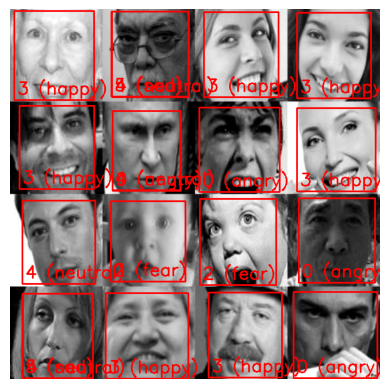

In [36]:
# Convert bounding boxes from inference back to original scaling
pred_boxes_scaled = scale_bboxes_to_original(
    pred_boxes, 
    scale, 
    pad_left, 
    pad_top, 
    img_w, 
    img_h
)

# Convert scaled bounding box to YOLO format labels
pred_labels_yolo = predictions_to_yolo_format(
    pred_boxes_scaled, 
    pred_classes, 
    img_w, 
    img_h
)

print(img_np.shape)

# Visualize predictions on original image
for i, label in enumerate(pred_labels_yolo):
    c = int(label[0])
    print(f"{c} ({class_names[c]}) with confidence {round(pred_scores[i], 2)} " \
         f"at {[round(v.item(), 4) for v in label[1:]]}")
visualize_sample(img_np, pred_labels_yolo, class_names, (255, 0, 0))